In [1]:
# Setup
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import imageio
from utils import make_env, orthogonal_init
from google.colab import drive
drive.mount('/content/gdrive')

# Hyperparameters from the PPO implementation
total_steps = int(8e6)
num_envs = 32
num_steps = 256
num_levels = 100 
feature_dim = 512

# We store the mean rewards each num_envs * num_steps steps
# Steps taken in M
steps_taken = np.arange(num_envs*num_steps,
                        int(np.ceil(total_steps/(num_envs*num_steps)))*num_envs*num_steps+1,
                        num_envs*num_steps)/1000000

--2020-12-05 18:58:22--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]  14.46K  --.-KB/s    in 0s      

2020-12-05 18:58:22 (104 MB/s) - ‘utils.py.2’ saved [14807/14807]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def decode_experiment_name(name):
  components = name.split('_')
  experiment_name = 'Nature'
  if components[1] == 'i':
    experiment_name = 'Impala'
  if components[2] == 'mx':
    experiment_name += ': Mix Reg'
  elif components[2] == 'rc':
    experiment_name += ': Rand Cut' 
  elif components[2] == 'addfc':
    experiment_name += ': Add FCL' 
  return experiment_name

In [3]:
# Function that plots the training mean reward as a function of steps for
# each experiment of a specific game
def plot_training_performance(game_name):
  path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

  # Get the stored rewards for each experiment
  rewards = []
  experiment_names = []
  for filename in os.listdir(path):
    if filename.endswith(".pt"):
      experiment_names.append(filename)
      file_load = torch.load(path + filename)
      rewards.append(file_load['Mean Reward'])
  print('Number of experiments done for ' + game_name + ': ' + str(len(experiment_names)))
  print('Experiment names: ' + str(experiment_names))

  # Plot the mean rewards for each experiment
  plt.figure(figsize = (16, 10))
  for i in range(len(experiment_names)):
    mean_rewards = [r.item() for r in rewards[i]] # From tensores to a list of reward values
    plt.plot(steps_taken, mean_rewards, label=decode_experiment_name(experiment_names[i]))
    plt.legend()
  plt.xlabel('Steps (M)')
  plt.ylabel('Mean Reward')
  plt.title(game_name + ' Training Rewards')
  plt.show()

Number of experiments done for Starpilot: 8
Experiment names: ['sd_i_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_i_mx_sp.pt', 'sd_n_na_sp.pt', 'sd_n_rc_sp.pt', 'sd_i_na_sp.pt', 'sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt']


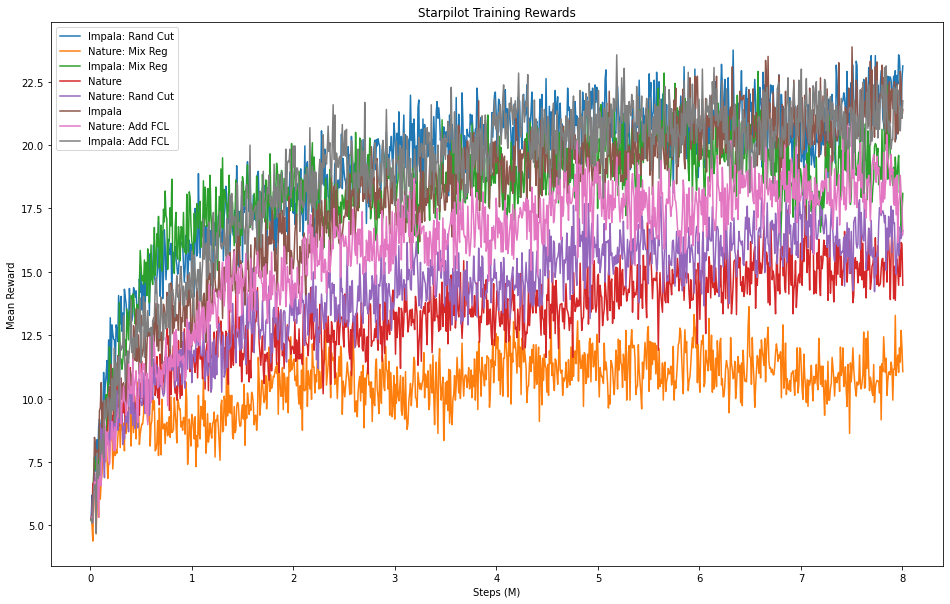

In [4]:
plot_training_performance('Starpilot')

Number of experiments done for Coinrun: 6
Experiment names: ['sd_n_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_i_na_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_rc_cr.pt']


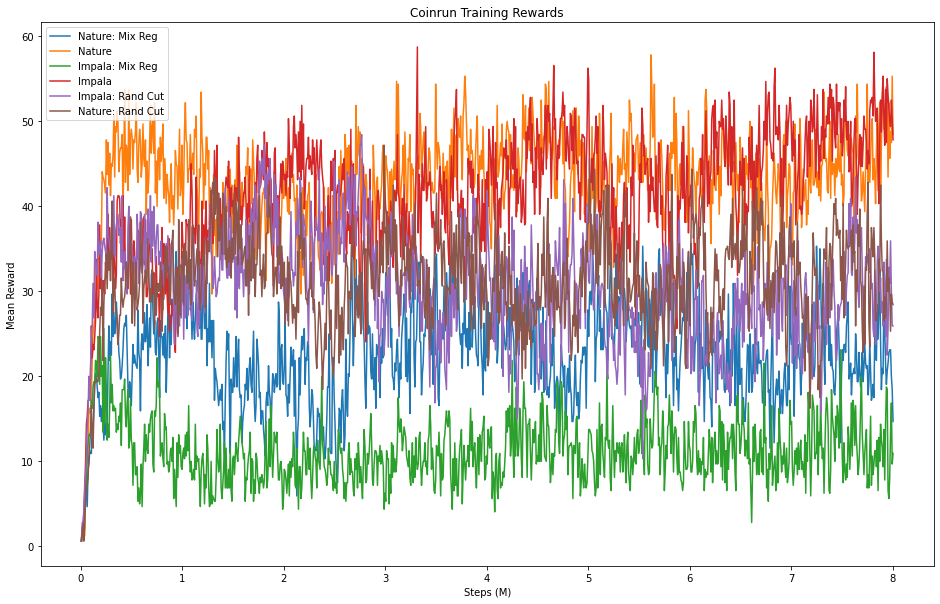

In [5]:
plot_training_performance('Coinrun')

In [6]:
#plot_training_performance('Dodgeball')

In [7]:
# Function that plots the total training time for each experiment of a specific game
def plot_training_time(game_name):
  path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

  # Get the stored training times for each experiment
  train_time = []
  experiment_names = []
  for filename in os.listdir(path):
    if filename.endswith(".pt"):
      experiment_names.append(filename)
      file_load = torch.load(path + filename)
      train_time.append(file_load['Training time'])
  train_time_hours = [t / (60*60) for t in train_time]
  experiment_names_decode = [decode_experiment_name(n) for n in experiment_names]
  print('Experiment names: ' + str(experiment_names))
  print('Total training time in hours: ' + str(train_time_hours))

  # Plot the results as a horizontal bar chart
  y_pos = np.arange(len(experiment_names))
  plt.barh(y_pos, train_time_hours, align='center', alpha=0.5)
  plt.yticks(y_pos, experiment_names_decode)
  plt.xlabel('Training time (h)')
  plt.title('Experiment total training time: ' + game_name)
  plt.show()

Experiment names: ['sd_i_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_i_mx_sp.pt', 'sd_n_na_sp.pt', 'sd_n_rc_sp.pt', 'sd_i_na_sp.pt', 'sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt']
Total training time in hours: [5.321246093180444, 3.1125076474746067, 6.110621115962664, 3.077574242287212, 2.8564540678924986, 5.466291068196297, 3.3079904033078087, 4.563323624332746]


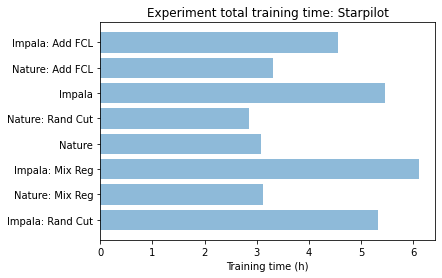

In [8]:
plot_training_time('Starpilot')

Experiment names: ['sd_n_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_i_na_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_rc_cr.pt']
Total training time in hours: [5.879301840464274, 5.6665330611997184, 7.64159921420945, 5.811231755481826, 5.9349523402584925, 5.702107902169228]


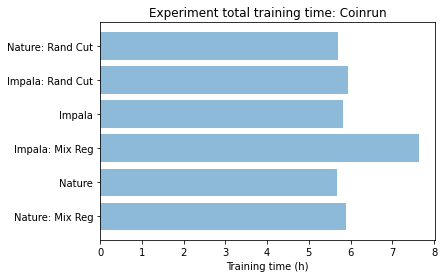

In [9]:
plot_training_time('Coinrun')

In [10]:
#plot_training_time('Dodgeball')

In [11]:
# Define the necessary classes and functions for test performance
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class NatureEncoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    return self.layers(x)

class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)
    
    return dist, value

class Policy_add_FCL(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy_add_FCL = nn.Linear(feature_dim, int(feature_dim/2))
    self.policy = orthogonal_init(nn.Linear(int(feature_dim/2), num_actions), gain=.01)
    self.value_add_FCL = nn.Linear(feature_dim, int(feature_dim/2))
    self.value = orthogonal_init(nn.Linear(int(feature_dim/2), 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    pol_add = F.relu(self.policy_add_FCL(x))
    logits = self.policy(pol_add)
    val_add = F.relu(self.value_add_FCL(x))
    value = self.value(val_add).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)
    
    return dist, value

def xavier_uniform_init(module, gain=1.0):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight.data, gain)
        nn.init.constant_(module.bias.data, 0)
    return module

class ResidualBlock(nn.Module):
    def __init__(self,in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = nn.ReLU()(x)
        out = self.conv1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImpalaBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.res1 = ResidualBlock(out_channels)
        self.res2 = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class ImpalaEncoder(nn.Module):
    def __init__(self,in_channels,out_features,**kwargs):
        super().__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(in_features=32 * 8 * 8, out_features=out_features)

        self.output_dim = feature_dim
        self.apply(xavier_uniform_init)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = nn.ReLU()(x)
        x = Flatten()(x)
        x = self.fc(x)
        x = nn.ReLU()(x)
        return x


In [12]:
# Function that plots the test mean reward for each experiment of a specific game
# There is also an option to save test videos for each experiment by setting 
# save_videos = True and supplying the path to save the videos
def plot_training_performance(game_name, save_videos=False, 
                              vid_path = r'/content/gdrive/MyDrive/Deep Learning Project 2020/Videos'):
  # Get the stored policies for each experiment
  path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

  policies = []
  experiment_names = []
  for filename in os.listdir(path):
    if filename.endswith(".pt"):
      experiment_names.append(filename)
      file_load = torch.load(path + filename)
      policies.append(file_load['policy_state_dict'])
  experiment_names_decode = [decode_experiment_name(n) for n in experiment_names]
  print('Experiment file names: ' + str(experiment_names))
  print('Experiment names: ' + str(experiment_names_decode))

  env = make_env(num_envs, num_levels=num_levels, env_name=game_name.lower())
  num_actions = env.action_space.n
  in_channels = env.observation_space.shape[0]

  mean_rewards = []
  # Run through each experiment
  for i in range(len(experiment_names)):
    # Define the encoder used
    if experiment_names[i].split('_')[1] == 'i':
      encoder = ImpalaEncoder(in_channels, feature_dim)
    else:
      encoder = NatureEncoder(in_channels, feature_dim)

    # Define and load the policy to use
    if experiment_names[i].split('_')[2] == 'addfc':
      policy = Policy_add_FCL(encoder, feature_dim, num_actions)
    else:
      policy = Policy(encoder, feature_dim, num_actions)
    policy.cuda()
    policy.load_state_dict(policies[i])

    # Now for evaluating generalization. We can generated a distinct test sets for each environment 
    # Make evaluation environment using levels that the models have not seen before
    eval_env = make_env(num_envs, start_level=num_levels, num_levels=num_levels,
                        env_name=game_name.lower())
    obs = eval_env.reset()

    frames = []
    total_reward = []

    # Evaluate policy
    policy.eval()
    for _ in range(512):

      # Use policy
      action, log_prob, value = policy.act(obs)

      # Take step in environment
      obs, reward, done, info = eval_env.step(action)
      total_reward.append(torch.Tensor(reward))

      # Render environment and store
      frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
      frames.append(frame)

    # Calculate average return
    mean_reward = torch.stack(total_reward).sum(0).mean(0)
    mean_rewards.append(mean_reward.item())

    if(save_videos):
      # Store it in videos folder
      if not os.path.exists(vid_path):
        os.makedirs(vid_path)

      # Save frames as video
      frames = torch.stack(frames)
      imageio.mimsave(vid_path+'/vid_' + game_name + '_' + experiment_names_decode[i].replace(' ', '') + '.mp4', frames, fps=25)
  print('Mean test rewards: ' + str(mean_rewards))

  # Plot the results as a horizontal bar chart
  y_pos = np.arange(len(experiment_names))
  plt.barh(y_pos, mean_rewards, align='center', alpha=0.5)
  plt.yticks(y_pos, experiment_names_decode)
  plt.xlabel('Mean Reward')
  plt.title(game_name + ' Experiment Mean Test Rewards')
  plt.show()

Experiment file names: ['sd_i_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_i_mx_sp.pt', 'sd_n_na_sp.pt', 'sd_n_rc_sp.pt', 'sd_i_na_sp.pt', 'sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt']
Experiment names: ['Impala: Rand Cut', 'Nature: Mix Reg', 'Impala: Mix Reg', 'Nature', 'Nature: Rand Cut', 'Impala', 'Nature: Add FCL', 'Impala: Add FCL']
Mean test rewards: [19.57583236694336, 15.00926399230957, 17.042003631591797, 16.873620986938477, 17.751243591308594, 18.33036231994629, 18.248615264892578, 18.646053314208984]


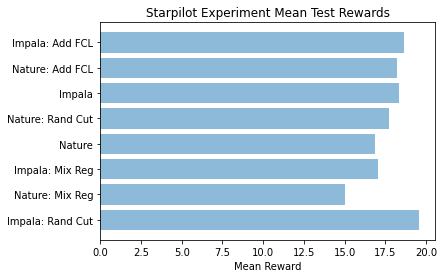

In [13]:
plot_training_performance('Starpilot', True)

Experiment file names: ['sd_n_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_i_na_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_rc_cr.pt']
Experiment names: ['Nature: Mix Reg', 'Nature', 'Impala: Mix Reg', 'Impala', 'Impala: Rand Cut', 'Nature: Rand Cut']
Mean test rewards: [45.3161735534668, 63.67683029174805, 22.2877197265625, 62.229549407958984, 57.49186325073242, 55.209476470947266]


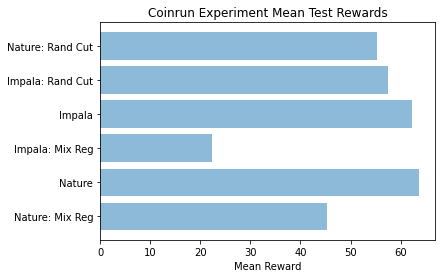

In [14]:
plot_training_performance('Coinrun', True)

In [15]:
#plot_training_performance('Dodgeball', True)